In [43]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from dataUtils import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.spatial.transform import Rotation as R

import dataUtils as du

# Load Data

TOTAL FRAMES: 729 (729)
INVALID FRAMES: 4, VALID FRAMES: 725
STRING POSITIONS: 725, EXAMPLE: [-5, -5, -5, -5, -5, -5]


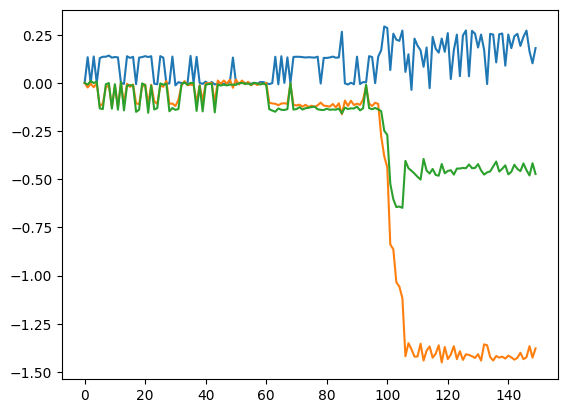

In [44]:
path_base = "../Data/"
a = 100 #acceleration in steps
hz = 30
samples = 3 #steps in gridsearch
stepsize = 5
full_path = r"C:\Users\DGaard\Desktop\Gits\Master_MRI_Phantom\Tracking\Data\phantom_data_5step.csv"#path_base + "phantom_data_20step.csv"
num_meta_rows = 6

#load all data
df = du.load_dataset(a,samples,stepsize,path_base, full_path)
#print(df.head)
df = du.fixCoordinates(df)
#print(df.head)

#get valid frames (frames without wobeling/ocscilation)
start_offset = 90#65#83 #(frame before action)
wanted_frames = samples ** 6 #amount of frames to extract
frame_offset = 2*hz #time between moves
spacing = 10 #how many previous frames that have to be still
t_eps = 0.5 #translational error
r_eps =0.5 #rotational error

df_valid, valid_idx = du.getValidFrames(df,wanted_frames,frame_offset,start_offset,spacing,t_eps,r_eps)

#load tagets
#comb_list = np.load("../../Arduino/20shuffled_targets.npy")
comb_list = du.getGridsearchCableLengths(stepsize)
comb_list = du.getValidTargets(comb_list,valid_idx)
print(f"STRING POSITIONS: {len(comb_list)}, EXAMPLE: {comb_list[0]}")

plt.plot(df["X_trans"][0:150])
plt.plot(df["Y_trans"][0:150])
plt.plot(df["Z_trans"][0:150])

# NORMALIZE DATA


In [45]:

# seed = 42
# # Assuming df is your pandas DataFrame
# # Normalize translations in DF
# col = [ "X_trans", "Y_trans", "Z_trans"]
# X_norm = df_valid.copy()
# for c in col:
#   X_norm[c] = 2 * (X_norm[c] - X_norm[c].min()) / (X_norm[c].max() - X_norm[c].min()) - 1
# # Selecting features from column index 2 to 7 (exclusive of 8)
# X =X_norm.iloc[:, 2:8].values
# print(X.shape)


# rotations = X[:, :3]
# translations = X[:, 3:]
# # Define the positions of 4 points spaced around the original pivot point
# # These positions are relative to the pivot point before rotation
# point_offsets = np.array([[1, 0, 1],  # Point 1
#                            [0, 1, -1],  # Point 2
#                            [-1, -1, 0], # Point 3
#                            [-1, 0, -1]])# Point 4

# # Convert Euler angles to rotation matrices
# rot_matrices = R.from_euler('xyz', rotations, degrees=True).as_matrix()

# # Apply rotation to the point offsets
# rotated_points = np.matmul(rot_matrices, point_offsets.transpose())
# rotated_points = np.transpose(rotated_points, axes=(0, 2, 1))

# for i in range(rotated_points.shape[0]):
#   for point in rotated_points[i]:
#     point[0] += translations[i,0]
#     point[1] += translations[i,1]
#     point[2] += translations[i,2]
# rotated_points = rotated_points.reshape(-1,12)

# X = rotated_points#np.concatenate((rotated_points,translations),axis = 1) #np.concatenate((rotated_points, translations), axis=1)
# # 12 features, xyz xyz xyz xyz
# min_xs, max_xs = min([np.min(X[:,0]),np.min(X[:,3]),np.min(X[:,6]),np.min(X[:,9])]), max([np.max(X[:,0]),np.max(X[:,3]),np.max(X[:,6]),np.max(X[:,9])])
# min_ys, max_ys = min([np.min(X[:,1]),np.min(X[:,4]),np.min(X[:,7]),np.min(X[:,10])]), max([np.max(X[:,1]),np.max(X[:,4]),np.max(X[:,7]),np.max(X[:,10])])
# min_zs, max_zs = min([np.min(X[:,2]),np.min(X[:,5]),np.min(X[:,8]),np.min(X[:,11])]), max([np.max(X[:,2]),np.max(X[:,5]),np.max(X[:,8]),np.max(X[:,11])])

# print(min_xs,max_xs)
# print(min_ys,max_ys)
# print(min_zs,max_zs)
# print(X.shape)

# #normalize all vectors based on their max/min x,y or z value
# for i in range(X.shape[0]):
#   for x in [0,3,6,9]:
#     X[i,x] = 2*((X[i,x]-min_xs)/(max_xs-min_xs)) - 1
#   for y in [1,4,7,10]:
#     X[i,y] = 2*((X[i,y]-min_ys)/(max_ys-min_ys)) -1
#   for z in [2,5,8,11]:
#     X[i,z] = 2*((X[i,z]-min_zs)/(max_zs-min_zs)) -1


# # Assuming your output targets are in the columns from index 8 onwards
# Y = np.array(comb_list)

# # Split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=seed)


# LOAD MODEL VERSION

In [46]:
# Create the model
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForwardNN, self).__init__()
        #self.bn1 = nn.BatchNorm1d(6)
        self.fc1 = nn.Linear(input_size, hidden_size)
        #self.bn2 = nn.BatchNorm1d(30)
        self.dropout1 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        #self.bn3 = nn.BatchNorm1d(30)
        self.dropout2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        #self.bn4 = nn.BatchNorm1d(30)
        self.dropout3 = nn.Dropout(p=0.1)
        self.fc4 = nn.Linear(hidden_size, output_size)

        #self.fc5 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        #x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        #x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        #x = self.dropout3(x)
        x = self.fc4(x)
        return x

#model = torch.load("models/3hid_32_neu_500epoch_p001lr_norm-11_random20.pth")
#model = torch.load(r"C:\Users\DGaard\Desktop\Gits\Master_MRI_Phantom\Tracking\src\models\3hid_32_neu_100epoch_p001lr_norm-11_20.pth")
#model = torch.load(r"C:\Users\DGaard\Desktop\Gits\Master_MRI_Phantom\Tracking\src\models\3hid_32_neu_500epoch_p001lr_norm-11.pth")
model = torch.load(r"C:\Users\DGaard\Desktop\Gits\Master_MRI_Phantom\Tracking\src\models\3hid_32_neu_500epoch_p001lr_norm-11_step5.pth")

# Define loss function and optimizer
criterion = nn.MSELoss()
L1 = nn.L1Loss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed
seed = 42
batch_size = 1
# Split data into train and test sets
col = ["X_trans", "Y_trans", "Z_trans", "X_rot", "Y_rot", "Z_rot"]
X_norm = df_valid[col].copy()

Y = np.array(comb_list)
#X = X_norm.iloc[:].values

for i in range(6):
  X_norm[col[i]] = 2 * (X_norm[col[i]] - X_norm[col[i]].min()) / (X_norm[col[i]].max() - X_norm[col[i]].min()) - 1
  
X_train, X_test, y_train, y_test = train_test_split(X_norm.values, Y, test_size=0.15, random_state=seed)


#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=seed)
train_data_tensor = torch.tensor(X_train, dtype=torch.float32)
targets_tensor = torch.tensor(y_train, dtype=torch.float32)
val_data_tensor = torch.tensor(X_test, dtype=torch.float32)
val_targets_tensor = torch.tensor(y_test, dtype=torch.float32)

# Combine the input data and target values into a TensorDataset
train_dataset = TensorDataset(train_data_tensor, targets_tensor)
test_dataset = TensorDataset(val_data_tensor, val_targets_tensor)

# Create a DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [47]:
def toNumpy(tensors):
  arr = [tensor.numpy() for tensor in tensors]

  # Create a NumPy array containing these NumPy arrays
  arr = np.array(arr)
  return arr

# TEST MODEL ON DATA

In [48]:
#TRAINING
# Lists to store training and validation losses
val_pred = []
val_target = []
val_losses = []
val_l1 = []
train_pred = []
train_target = []
train_losses = []
train_l1 = []

# Initialize early stopping parameters
# best_val_loss = np.Inf
# patience = 15
# counter = 0

# Validation loop
model.eval()  # Set the model to evaluation mode
running_val_loss = 0.0
running_train_loss = 0.0
with torch.no_grad():
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        running_train_loss += loss.item()
        train_losses.append(loss.item())
        l1 = L1(outputs,targets)
        train_l1.append(l1.item())
        train_pred.append(outputs)
        train_target.append(targets)
with torch.no_grad():
    for inputs, targets in val_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        running_val_loss += loss.item()
        val_losses.append(loss.item())
        l1 = L1(outputs,targets)
        val_l1.append(l1.item())
        val_pred.append(outputs)
        val_target.append(targets)
# Compute average validation loss for the epoch
average_val_loss = running_val_loss / len(val_loader)
average_train_loss = running_train_loss / len(train_loader)

# Print training and validation loss for the epoch
print(f"Mean Training MSE: {average_train_loss}, Mean Training STD: {np.std(np.array(train_losses))}")
print(f"Mean Training L1: {np.mean(np.array(train_l1))}, Mean Training STD: {np.std(np.array(train_l1))}")
print(f"Mean Test MSE: {average_val_loss}, Mean Test STD: {np.std(np.array(val_losses))}")
print(f"Mean Test L1: {np.mean(np.array(val_l1))}, Mean Test STD: {np.std(np.array(val_l1))}")

Mean Training MSE: 0.11343258979704605, Mean Training STD: 0.1634622978343193
Mean Training L1: 0.2316344608915607, Mean Training STD: 0.11509022922671396
Mean Test MSE: 0.21801814795770777, Mean Test STD: 0.3149403976711026
Mean Test L1: 0.29054145908000273, Mean Test STD: 0.15425312384946674


In [49]:
train_pred = toNumpy(train_pred)
train_target = toNumpy(train_target)
test_pred = toNumpy(val_pred)
test_target = toNumpy(val_target)

In [50]:
# Calculate MSE loss for each column
mse_train = np.mean((train_pred - train_target)**2, axis=0)
l1_train = np.mean((abs(train_pred - train_target)), axis=0)
mse_test = np.mean((test_pred - test_target)**2, axis=0)
l1_test = np.mean((abs(test_pred - test_target)), axis=0)
print(f"MSE Train: {mse_train[0]}")
print(f"L1 Train: {l1_train[0]}")
print(f"MSE Test: {mse_test[0]}")
print(f"L1 Test: {l1_test[0]}")

MSE Train: [0.06348994 0.12074701 0.14426206 0.06306894 0.19520602 0.0938216 ]
L1 Train: [0.17657867 0.2570589  0.26082215 0.19158247 0.26971236 0.23405232]
MSE Test: [0.08805447 0.16811594 0.25139886 0.06549132 0.42107806 0.31397033]
L1 Test: [0.21459422 0.29854771 0.3388292  0.19645363 0.3770342  0.3177895 ]
